<a href="https://colab.research.google.com/github/Chaitali2004/Anomaly-detection-in-network-traffic/blob/main/Anomally_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd


In [5]:
# Define your feature list (42 + label)
features = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label']
print(" Dataset loaded successfully")


 Dataset loaded successfully


In [6]:
# Step 2: Load the dataset
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Colab Notebooks/kddcup.data.corrected"
df = pd.read_csv(file_path, names=features, header=None)

print(df.head())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        215      45076     0   
1         0           tcp    http   SF        162       4528     0   
2         0           tcp    http   SF        236       1228     0   
3         0           tcp    http   SF        233       2032     0   
4         0           tcp    http   SF        239        486     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   0   
1               0       0    0  ...                   1   
2               0       0    0  ...                   2   
3               0       0    0  ...                   3   
4               0       0    0  ...                   4   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     0.0                 

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#  Step 2: Clean the labels FIRST
df['label'] = df['label'].str.strip('.')  # strip the dots

#  Step 3: Convert label to binary
df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)


In [9]:

# Step 4: Print verification
print(" Data loaded successfully")
print(df[['label', 'binary_label']].head())
print("Shape of dataset:", df.shape)
print("Attack class counts:\n", df['binary_label'].value_counts())

#  Check unique labels
output = df['label'].values
labels = set(output)
print('The different type of output labels are:', labels)
print('='*100)
print('No. of different output labels are:', len(labels))

# Step 5: Clean further
print(" Checking nulls:\n", df.isnull().sum())
df = df.drop_duplicates()
print(" Duplicates removed")
print(" Data types:\n", df.dtypes)

 Data loaded successfully
    label  binary_label
0  normal             0
1  normal             0
2  normal             0
3  normal             0
4  normal             0
Shape of dataset: (4898431, 43)
Attack class counts:
 binary_label
1    3925650
0     972781
Name: count, dtype: int64
The different type of output labels are: {'perl', 'phf', 'ftp_write', 'teardrop', 'nmap', 'portsweep', 'multihop', 'buffer_overflow', 'satan', 'warezmaster', 'loadmodule', 'rootkit', 'guess_passwd', 'smurf', 'neptune', 'back', 'ipsweep', 'land', 'warezclient', 'imap', 'pod', 'normal', 'spy'}
No. of different output labels are: 23
 Checking nulls:
 duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              

In [10]:
import joblib

y = joblib.load('/content/drive/My Drive/Colab Notebooks/data/y.pkl')
print(" y loaded successfully. Shape:", y.shape)


 y loaded successfully. Shape: (1074992,)


In [11]:
X_scaled = joblib.load('/content/drive/My Drive/Colab Notebooks/data/X_scaled.pkl')
y = joblib.load('/content/drive/My Drive/Colab Notebooks/data/y.pkl')

#train isolation forest model
from sklearn.ensemble import IsolationForest

iso_model = IsolationForest(contamination=0.1, random_state=42)
iso_model.fit(X_scaled)

# Predict (-1 = anomaly, 1 = normal)
preds = iso_model.predict(X_scaled)

# Convert to 0/1 (to match y)
preds = [1 if p == -1 else 0 for p in preds]


 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84    812814
           1       0.37      0.15      0.21    262178

    accuracy                           0.73   1074992
   macro avg       0.57      0.53      0.53   1074992
weighted avg       0.67      0.73      0.68   1074992

 Confusion Matrix:
 [[744872  67942]
 [222620  39558]]


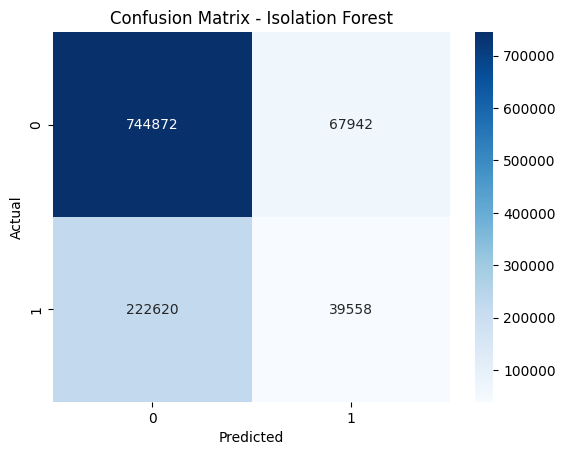

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(" Classification Report:\n", classification_report(y, preds))
print(" Confusion Matrix:\n", confusion_matrix(y, preds))

# Confusion Matrix Plot
sns.heatmap(confusion_matrix(y, preds), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Isolation Forest')
plt.show()


Autoencoder for Anomally Detection

In [13]:
# build autoencoders
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_dim = X_scaled.shape[1]
encoding_dim = 32  # compression factor

input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation="relu")(input_layer)
encoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')


In [14]:
#Train the Autoencoder ONLY on normal traffic
X_train = X_scaled[y == 0]  # Use only normal data

history = autoencoder.fit(X_train, X_train,
                          epochs=20,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)


Epoch 1/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.3225 - val_loss: 0.6634
Epoch 2/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.3496 - val_loss: 0.6627
Epoch 3/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.3376 - val_loss: 0.6618
Epoch 4/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.3213 - val_loss: 0.6617
Epoch 5/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.3116 - val_loss: 0.6601
Epoch 6/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.3339 - val_loss: 0.6599
Epoch 7/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.3200 - val_loss: 0.6599
Epoch 8/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.3130 - val_loss: 0.6597
Epoch 9/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.3131 - val_loss: 0.6596
Epoch 10/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.4155 - val_loss: 0.6595
Epoch 11/20
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.3028 - val_loss: 0.6594
Epoch 12/20
2541/25

In [15]:
X_pred = autoencoder.predict(X_scaled)


33594/33594 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step


In [16]:
import numpy as np
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)


threshold = np.percentile(mse, 95)
y_pred = (mse > threshold).astype(int)


threshold = np.percentile(mse, 95)  # Adjust if needed
y_pred = (mse > threshold).astype(int)

#choose threshold and predict anomalies
threshold = np.percentile(mse, 95)  # Adjust if needed
y_pred = (mse > threshold).astype(int)



              precision    recall  f1-score   support

           0       0.79      0.99      0.88    812814
           1       0.92      0.19      0.31    262178

    accuracy                           0.80   1074992
   macro avg       0.85      0.59      0.60   1074992
weighted avg       0.82      0.80      0.74   1074992



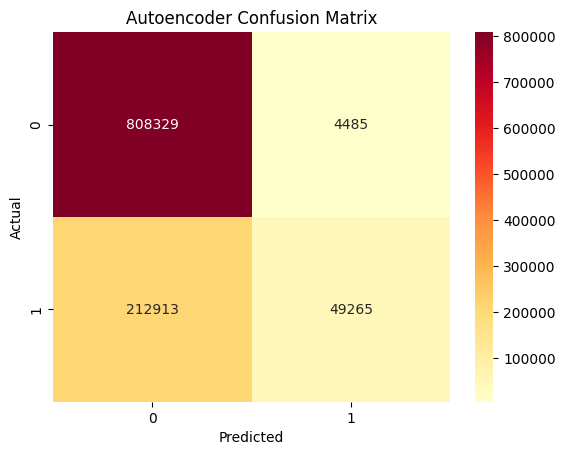

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y, y_pred))

sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Autoencoder Confusion Matrix')
plt.show()


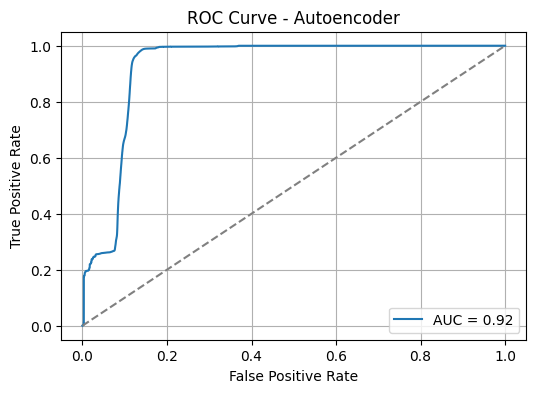

In [18]:
#ROC-AUC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y, mse)   # `mse` is reconstruction error
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Autoencoder')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

# Take a subset for faster computation
subset_size = 10000
idx = np.random.choice(X_scaled.shape[0], subset_size, replace=False)
X_small = X_scaled[idx]
y_small = y[idx]

# Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42, n_jobs=-1)
y_iso = iso.fit_predict(X_small)
y_iso = np.where(y_iso == -1, 1, 0)
print("Isolation Forest:\n", classification_report(y_small, y_iso))




Isolation Forest:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      7551
           1       0.46      0.19      0.27      2449

    accuracy                           0.75     10000
   macro avg       0.62      0.56      0.56     10000
weighted avg       0.70      0.75      0.70     10000



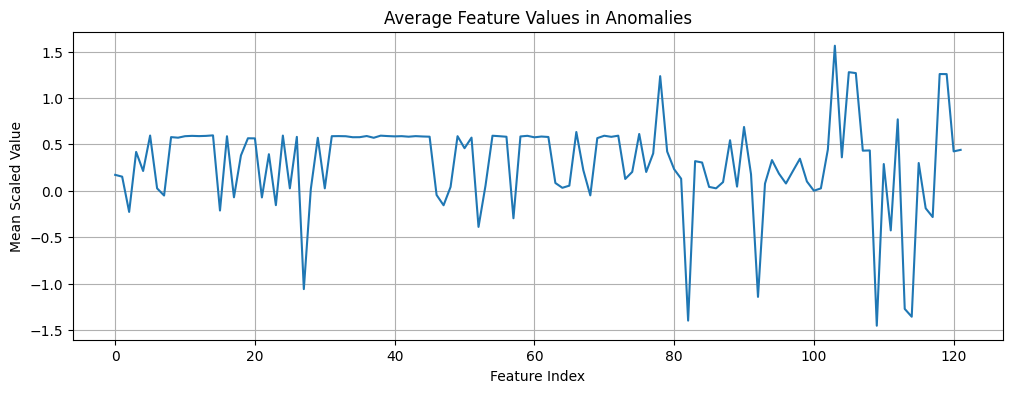

In [21]:
#Feature Importance in Anomalies
anomaly_data = X_scaled[y_pred == 1]  # predicted anomalies
avg_feature_values = np.mean(anomaly_data, axis=0)

plt.figure(figsize=(12,4))
plt.plot(avg_feature_values)
plt.title("Average Feature Values in Anomalies")
plt.xlabel("Feature Index")
plt.ylabel("Mean Scaled Value")
plt.grid(True)
plt.show()
from keras.models import load_model





## PHASE 3: t-SNE or PCA Visualization

In [22]:
import numpy as np

# Define the number of rows you want to sample
subset_size = 5000

# Randomly pick row indices
idx = np.random.choice(X_scaled.shape[0], subset_size, replace=False)
X_subset = X_scaled[idx]
y_subset = y[idx]
y_pred_subset = y_pred[idx]






In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_2d = tsne.fit_transform(X_subset)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


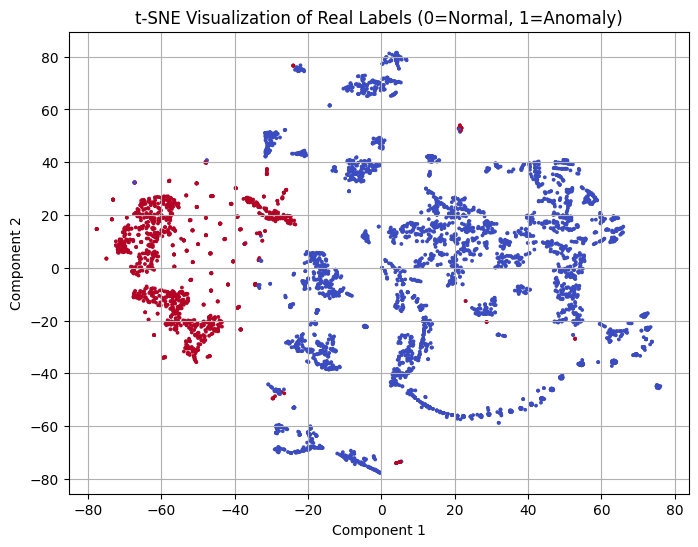

In [24]:
#plot actual labels
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_subset, cmap='coolwarm', s=3)
plt.title('t-SNE Visualization of Real Labels (0=Normal, 1=Anomaly)')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()



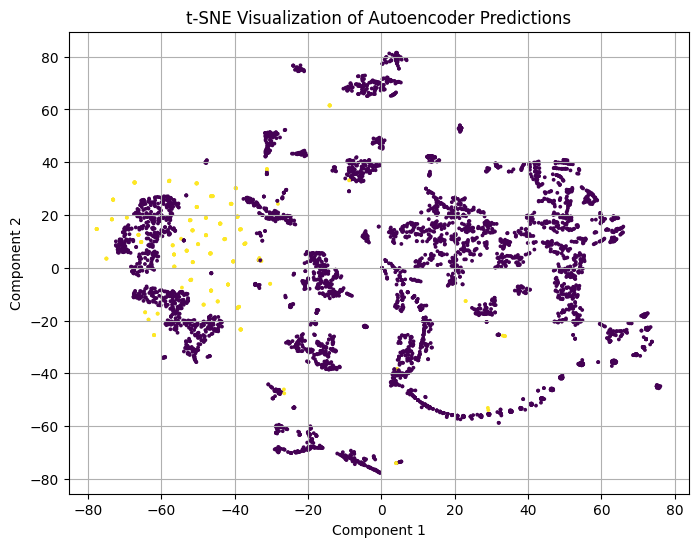

In [25]:
# Plot Autoencoder Predictions
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_pred_subset, cmap='viridis', s=3)
plt.title('t-SNE Visualization of Autoencoder Predictions')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()
